##**Project Overview**
---

This project aims to predict hospital readmission in US hospitals, by leveraging the historical medical claims dataset which contains various patients data like readmission period, tests, medications, diagnostic test results etc. By carefully looking at different variables about patients here, we aim to identify hospital readmission for diabetes patient. This understanding will allow healthcare professional to improve quality of care and reduce health care spending.

**Import the required dependencies.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, KFold
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
!pip install opendatasets
import opendatasets as od
import warnings
warnings.filterwarnings('ignore')

##**Data Extraction**
---

**Load the dataset from kaggle using kaggle api.**

In [2]:
od.download("https://www.kaggle.com/datasets/brandao/diabetes?select=diabetic_data.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rothindrohait
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/brandao/diabetes


**Load the dataset and transform it to make more analysis friendly.**

In [3]:
data=pd.read_csv("/content/diabetes/diabetic_data.csv")

In [4]:
data1=data.copy()
pd.set_option('display.max_columns', None)
data1.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
data1.describe(include="O")

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,5346,17018,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,3,3,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,Norm,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,2597,8216,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [7]:
data1.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


##**Data Cleaning and Preprocessing.**
---

In [8]:
for i in data1.columns:
  print(data1[i].value_counts(dropna=False).sort_values(ascending=False))
  print("*"*50)

encounter_id
55842        1
443867222    1
2278392      1
149190       1
64410        1
            ..
443797076    1
443797298    1
443804570    1
443811536    1
443816024    1
Name: count, Length: 101766, dtype: int64
**************************************************
patient_nbr
88785891    40
43140906    28
1660293     23
88227540    23
23199021    23
            ..
48988890     1
56799522     1
1057392      1
95063220     1
69986547     1
Name: count, Length: 71518, dtype: int64
**************************************************
race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64
**************************************************
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64
**************************************************
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)    

**Lets transfrom the target column (readmitted) into two category ("Yes" and "No")**

In [9]:
data1["readmitted"]=data1["readmitted"].replace({"NO": "No", "<30": "Yes", ">30": "Yes"})

- **I feel columns like "weight", "payer_code" and "medical_speciality" doesnt have any relation with weather patient has to re-admit or not. Therefore, its better to drop those**
- **Features like "examide" and "citoglipton" has only 1 category so it ll not have any short predictive capablity, therefore we will remove these 2 columns as well**
- **Features like "metformin-pioglitazone", "metformin-rosiglitazone", "glipizide-metformin", "glimepiride-pioglitazone", "troglitazone"  are extremly imbalanced, so it likely to have no or onesided predictive capablity so, again lets remove these as well**

In [10]:
data1.drop(columns=["weight", "payer_code", "medical_specialty", "examide", "citoglipton"], inplace=True)
data1.replace("?", np.nan, inplace=True)

In [11]:
data1["max_glu_serum"].replace(np.nan, "not measured", inplace=True)
data1["A1Cresult"].replace(np.nan, "not measured", inplace=True)

In [12]:
data1.dropna(subset=['race', 'diag_1', 'diag_2', 'diag_3'], inplace=True)

In [13]:
missing_percentage = data1.isna().sum() / len(data1) * 100
print(missing_percentage)

encounter_id                0.0
patient_nbr                 0.0
race                        0.0
gender                      0.0
age                         0.0
admission_type_id           0.0
discharge_disposition_id    0.0
admission_source_id         0.0
time_in_hospital            0.0
num_lab_procedures          0.0
num_procedures              0.0
num_medications             0.0
number_outpatient           0.0
number_emergency            0.0
number_inpatient            0.0
diag_1                      0.0
diag_2                      0.0
diag_3                      0.0
number_diagnoses            0.0
max_glu_serum               0.0
A1Cresult                   0.0
metformin                   0.0
repaglinide                 0.0
nateglinide                 0.0
chlorpropamide              0.0
glimepiride                 0.0
acetohexamide               0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglitazone                0.0
rosiglit

In [14]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98053 entries, 1 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              98053 non-null  int64 
 1   patient_nbr               98053 non-null  int64 
 2   race                      98053 non-null  object
 3   gender                    98053 non-null  object
 4   age                       98053 non-null  object
 5   admission_type_id         98053 non-null  int64 
 6   discharge_disposition_id  98053 non-null  int64 
 7   admission_source_id       98053 non-null  int64 
 8   time_in_hospital          98053 non-null  int64 
 9   num_lab_procedures        98053 non-null  int64 
 10  num_procedures            98053 non-null  int64 
 11  num_medications           98053 non-null  int64 
 12  number_outpatient         98053 non-null  int64 
 13  number_emergency          98053 non-null  int64 
 14  number_inpatient          

In [15]:
for i in data1.columns:
  print(data1[i].value_counts(dropna=False).sort_values(ascending=False))
  print("*"*50)

encounter_id
55842        1
443867222    1
149190       1
64410        1
500364       1
            ..
443797076    1
443797298    1
443804570    1
443811536    1
443816024    1
Name: count, Length: 98053, dtype: int64
**************************************************
patient_nbr
88785891    39
23199021    23
1660293     23
88227540    23
23643405    22
            ..
91372419     1
82028988     1
32338584     1
67063626     1
4496598      1
Name: count, Length: 68630, dtype: int64
**************************************************
race
Caucasian          75079
AfricanAmerican    18881
Hispanic            1984
Other               1484
Asian                625
Name: count, dtype: int64
**************************************************
gender
Female             52833
Male               45219
Unknown/Invalid        1
Name: count, dtype: int64
**************************************************
age
[70-80)     25306
[60-70)     21809
[80-90)     16702
[50-60)     16697
[40-50)      9265
[

**We can see "metformin-rosiglitazone" column has only 1 category so, its better to remove that column and also lets transform few other columns into proper category to have a better idea of the dataset.**

In [16]:
data1.drop(columns=["metformin-rosiglitazone"], inplace=True)

In [17]:
data1.duplicated().sum()

np.int64(0)

##**Feature Engineering / Feature Selection**
---

**Lets simplify the age column to have better understanding of the data.**

In [18]:
age_midpoints = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
data1['age'] = data1['age'].replace(age_midpoints)

**Baced on the ICD code, lets asign proper categories to the diagnosis column (diag_1 refers to "primary diagnosis", diag_2 refers to "secondary diagnosis" and diag_3 refers to "additional secondary diagnosis").**

In [19]:
for i, colum in enumerate(["diag_1", "diag_2", "diag_3"]):
  data1[colum] = pd.to_numeric(data1[colum], errors='coerce')  # Converts invalid entries to NaN
  data1[colum] = data1[colum].apply(lambda x: 'neoplasms' if x in range (140, 240)
    else 'diabetes' if x=="250.xx"
    else 'circulatory' if x in range(390, 460) or x == 784
    else 'respiratory' if x in range(460, 520) or x == 786
    else 'digestive' if x in range(520, 580) or x == 787
    else 'genitourinary' if x in range(580, 630) or x == 788
    else 'musculoskeletal' if x in range(710, 740)
    else 'injury' if x in range(800, 1000)
    else 'other')

**There is one category in gender column mentioned as "Unknown/Invalid", its unusual to have only 1 row with such value so lets apply forward fill to replace with other category.**

In [20]:
data1['gender']=data1['gender'].replace({"Unknown/Invalid": np.nan})
data1['gender']=data1['gender'].fillna(method="ffill")

In [21]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98053 entries, 1 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              98053 non-null  int64 
 1   patient_nbr               98053 non-null  int64 
 2   race                      98053 non-null  object
 3   gender                    98053 non-null  object
 4   age                       98053 non-null  int64 
 5   admission_type_id         98053 non-null  int64 
 6   discharge_disposition_id  98053 non-null  int64 
 7   admission_source_id       98053 non-null  int64 
 8   time_in_hospital          98053 non-null  int64 
 9   num_lab_procedures        98053 non-null  int64 
 10  num_procedures            98053 non-null  int64 
 11  num_medications           98053 non-null  int64 
 12  number_outpatient         98053 non-null  int64 
 13  number_emergency          98053 non-null  int64 
 14  number_inpatient          

In [22]:
data2=data1.copy()

**Now, we have 20+ drug columns in object format so, now lets change it to numerical type and it could lead to some problem when we have large number of columns; So, we will transfrom those columns into one for further analysis.**

In [23]:
for i in data2.columns:
  if data2[i].dtype=="object":
    ordnl=OrdinalEncoder()
    data2[i]=ordnl.fit_transform(data2[[i]])

In [24]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98053 entries, 1 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              98053 non-null  int64  
 1   patient_nbr               98053 non-null  int64  
 2   race                      98053 non-null  float64
 3   gender                    98053 non-null  float64
 4   age                       98053 non-null  int64  
 5   admission_type_id         98053 non-null  int64  
 6   discharge_disposition_id  98053 non-null  int64  
 7   admission_source_id       98053 non-null  int64  
 8   time_in_hospital          98053 non-null  int64  
 9   num_lab_procedures        98053 non-null  int64  
 10  num_procedures            98053 non-null  int64  
 11  num_medications           98053 non-null  int64  
 12  number_outpatient         98053 non-null  int64  
 13  number_emergency          98053 non-null  int64  
 14  number_inp

In [25]:
data2.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

**Let's combine all the 20+ drug column into one.**

In [26]:
column=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone']
data2['all_drugs']=data2[column].sum(axis=1)
data2.drop(columns=column, inplace=True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98053 entries, 1 to 101765
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              98053 non-null  int64  
 1   patient_nbr               98053 non-null  int64  
 2   race                      98053 non-null  float64
 3   gender                    98053 non-null  float64
 4   age                       98053 non-null  int64  
 5   admission_type_id         98053 non-null  int64  
 6   discharge_disposition_id  98053 non-null  int64  
 7   admission_source_id       98053 non-null  int64  
 8   time_in_hospital          98053 non-null  int64  
 9   num_lab_procedures        98053 non-null  int64  
 10  num_procedures            98053 non-null  int64  
 11  num_medications           98053 non-null  int64  
 12  number_outpatient         98053 non-null  int64  
 13  number_emergency          98053 non-null  int64  
 14  number_inp

**Check for Skewness.**

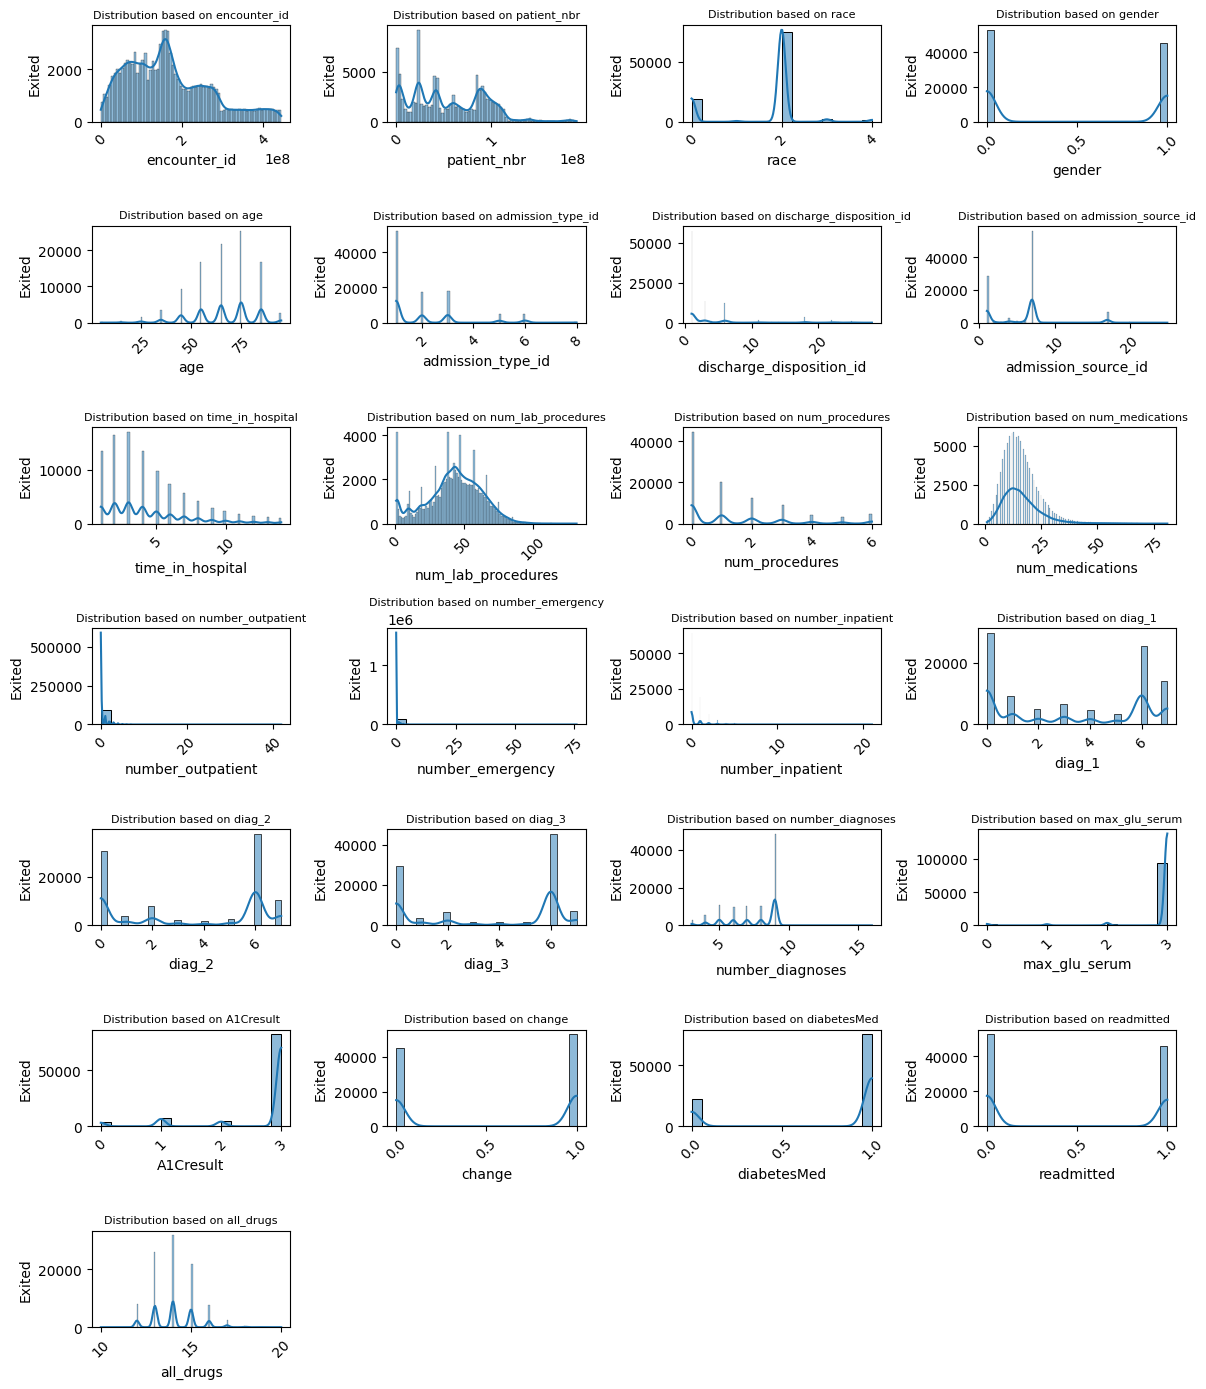

In [27]:
plt.figure(figsize=(12, 14))
for k, colu in enumerate(data2.columns):
  plt.subplot(7, 4, k+1)
  sns.histplot(data=data2, x=colu, kde=True)
  plt.xlabel(colu)
  plt.ylabel('Exited')
  plt.title(f'Distribution based on {colu}', fontsize=8)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
data2['num_medications_skew'] = data2['num_medications']**(1/3)
data2['num_lab_procedures_skew'] = data2['num_lab_procedures']**(1/2)
data2.drop(columns=['num_medications', 'num_lab_procedures'], inplace=True)

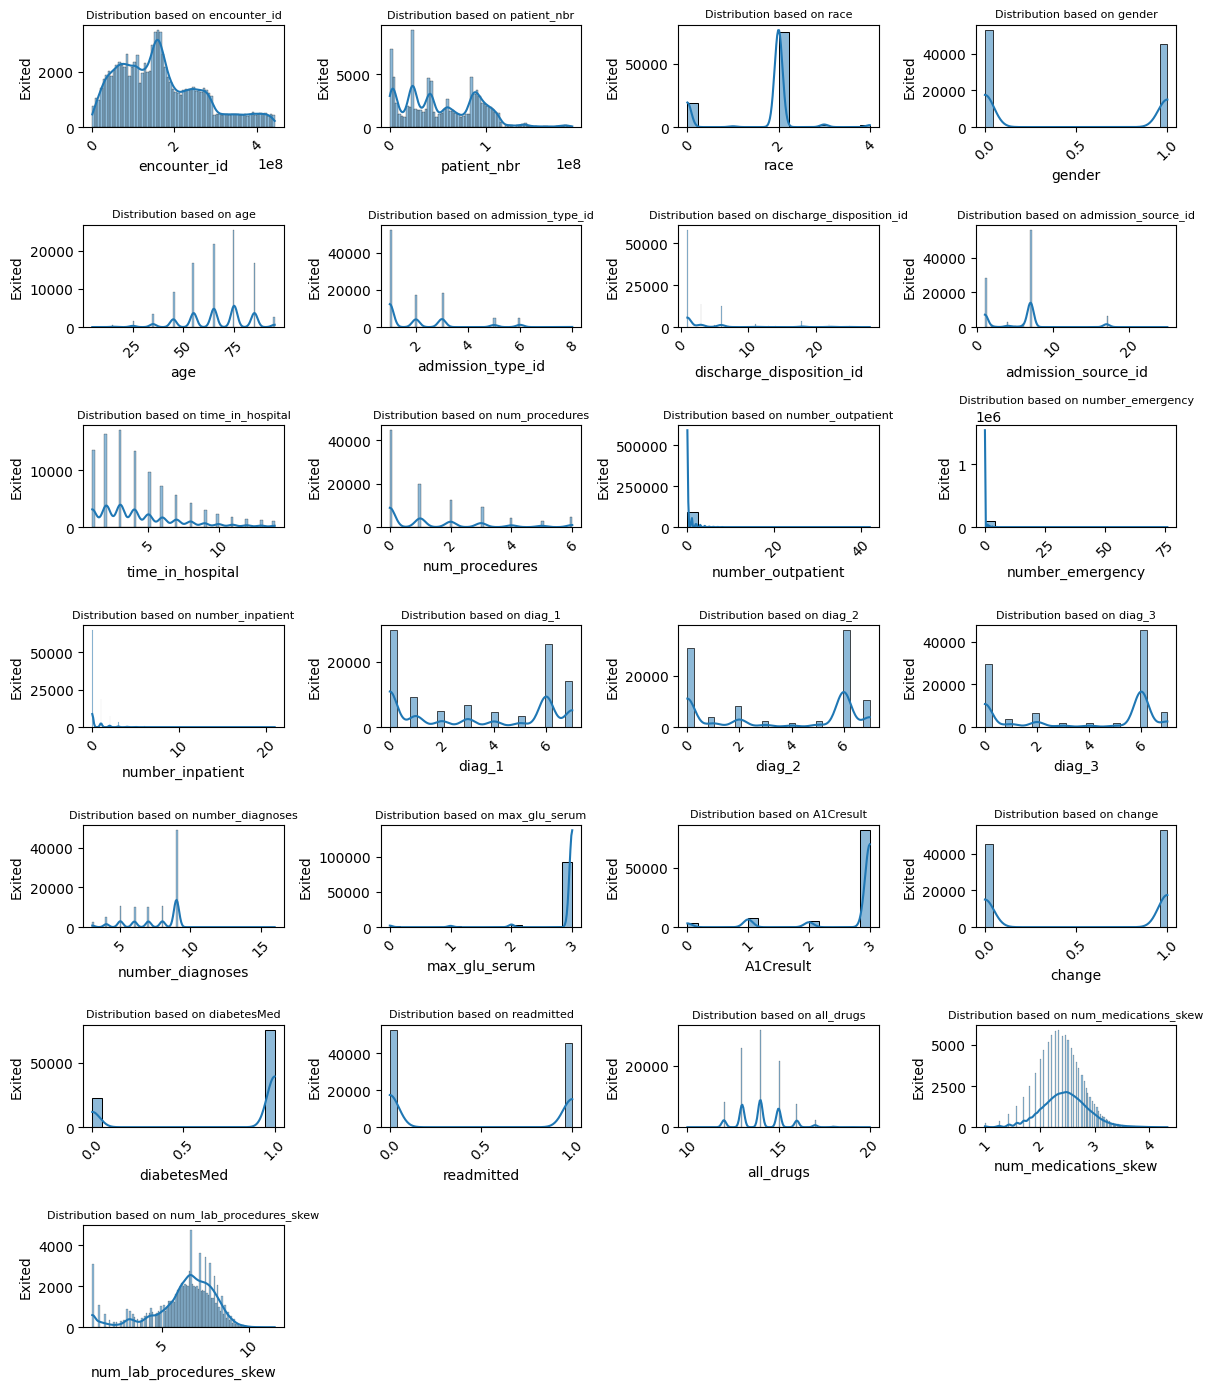

In [29]:
plt.figure(figsize=(12, 14))
for k, colu in enumerate(data2.columns):
  plt.subplot(7, 4, k+1)
  sns.histplot(data=data2, x=colu, kde=True)
  plt.xlabel(colu)
  plt.ylabel('Exited')
  plt.title(f'Distribution based on {colu}', fontsize=8)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Check for correlation.**

Correlations between features and target:
number_inpatient            0.215029
number_diagnoses            0.104414
number_emergency            0.101699
number_outpatient           0.079823
patient_nbr                 0.070123
diabetesMed                 0.062246
num_medications_skew        0.060724
time_in_hospital            0.048751
admission_source_id         0.037565
num_lab_procedures_skew     0.036117
age                         0.023031
A1Cresult                   0.011430
all_drugs                   0.004459
diag_1                      0.002073
race                        0.000055
admission_type_id          -0.005414
max_glu_serum              -0.013249
diag_2                     -0.013999
diag_3                     -0.015694
gender                     -0.017627
discharge_disposition_id   -0.017925
encounter_id               -0.043864
change                     -0.045096
num_procedures             -0.045895
Name: readmitted, dtype: float64


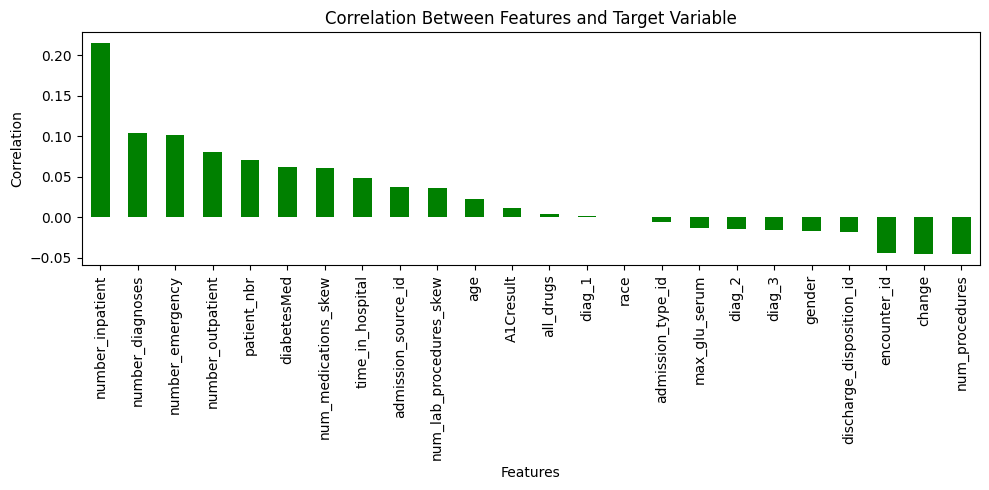

In [30]:
correlations = data2.corr()['readmitted'].sort_values(ascending=False).drop('readmitted')

print("Correlations between features and target:")
print(correlations)

# Visualize correlations
plt.figure(figsize=(10, 5))
correlations.plot(kind='bar', color='green')
plt.title('Correlation Between Features and Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Drop some columns that has low correlation i.e, correlation in between 0.01 to -0.01**

In [31]:
low_corr_columns = correlations[(correlations > -0.01) & (correlations < 0.01)].index
filtered=data2.drop(columns=low_corr_columns)

##**Model Training & Evaluation**
---

In [32]:
x=filtered.drop(columns=["readmitted"])
y=filtered["readmitted"]

**Standadize the dataset before proceding for model training.**

In [33]:
sc=StandardScaler()
x_tr_scaled=sc.fit_transform(x)

In [34]:
scoring = {
    'Accuracy': 'accuracy',
    'F1': 'f1_macro',
    'ROC-AUC': 'roc_auc_ovr'
    }
x_train, x_test, y_train, y_test = train_test_split(x_tr_scaled, y, test_size=0.3, random_state=42)

In [35]:
lgm=XGBClassifier()
lgm.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**Now lets evaluate the trained model on the test set.**

In [36]:
prediction=lgm.predict(x_test)
confusionmatrix=confusion_matrix(y_test, prediction)
accuracy=(confusionmatrix[0,0]+confusionmatrix[1,1])/np.sum(confusionmatrix)
precision = confusionmatrix[0,0]/(confusionmatrix[0,0]+confusionmatrix[1,0])
recall = confusionmatrix[0,0]/(confusionmatrix[0,0]+confusionmatrix[0,1])
f1 = 2*((precision*recall)/(precision+recall))
#fpr, tpr, threshhold = roc_curve(y_test, y_score)
#auc = roc_auc_score(y_test, y_score)
print("Confusion Matrix:\n", confusionmatrix)
print("Accuracy:", round(accuracy*100,2),"%")
print("Precision:", round(precision*100,2),"%")
print("Recall:", round(recall*100,2),"%")
print("F1-Score:", round(f1*100,2),"%")
#print("Area Under the ROC Curve:", round(auc*100,2),"%")

Confusion Matrix:
 [[11004  4618]
 [ 5384  8410]]
Accuracy: 66.0 %
Precision: 67.15 %
Recall: 70.44 %
F1-Score: 68.75 %


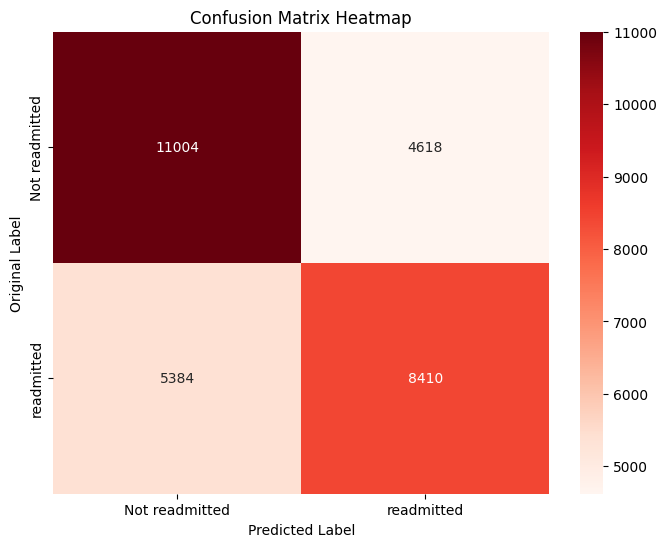

In [37]:
plt.figure(figsize=(8, 6))
class_names = ['Not readmitted', 'readmitted']
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Original Label')
plt.show()

**From the confusion matrix we can observe that the model tends to have more false negatives compared to false positives.**

- The model shows a decent 66% accuracy which means 66% of both positive and negatives were correct
- The model also shows quite good precision of 67%
-Recall of 70.4% indicates that the model is fairly good at catching most cases of readmission
-A F1-Score of 68.7% indicates that the model provides a balanced performance

**further we can tune the model to get the best performance, so we will apply hyperparameter tuning to search for the best parameters.**

##**Hyperparameter Tuning**
---

In [38]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
param={
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.4],  # Added 0.05 for finer control
    'max_depth': [2, 3, 4, 5, 6, 7],  # Extended upper bound
    'min_child_weight': [1, 3, 6, 8, 10],  # Lowered min value to 1
    'gamma': [0, 0.2, 0.4, 0.8, 1],  # Added 0 to check baseline
    'subsample': [0.6, 0.8, 1.0],  # CRITICAL missing parameter
    'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 2, 3, 4],  # L1 regularization
    'reg_lambda': [0, 1, 2, 4, 6, 8],  # L2 regularization
    'n_estimators': [500, 600, 700, 800, 900, 1000],  # Essential for performance
    'scale_pos_weight': [0.5, 1, 3, 5, 7]  # If class imbalance exists
}

In [39]:
best_model=RandomizedSearchCV(estimator=lgm, param_distributions=param, n_iter=10,
                              cv=cv, scoring=scoring, refit='Accuracy', random_state=42, verbose=3)
best_model.fit(x_train, y_train)
results_df = pd.DataFrame(best_model.cv_results_)
print(results_df[['params', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'mean_test_F1', 'mean_test_ROC-AUC']])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=800, reg_alpha=0, reg_lambda=8, scale_pos_weight=7, subsample=0.8; Accuracy: (test=0.469) F1: (test=0.326) ROC-AUC: (test=0.704) total time=   3.0s
[CV 2/10] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=800, reg_alpha=0, reg_lambda=8, scale_pos_weight=7, subsample=0.8; Accuracy: (test=0.470) F1: (test=0.328) ROC-AUC: (test=0.712) total time=   3.2s
[CV 3/10] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=800, reg_alpha=0, reg_lambda=8, scale_pos_weight=7, subsample=0.8; Accuracy: (test=0.470) F1: (test=0.328) ROC-AUC: (test=0.700) total time=   4.9s
[CV 4/10] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=800, reg_alpha=0, reg_lambda=8, scale_pos

**Now, lets look for the best parameters.**

In [40]:
final=best_model.best_estimator_

In [41]:
best_model.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'reg_lambda': 4,
 'reg_alpha': 2,
 'n_estimators': 900,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 1.0}

**Construct the final model with the best parameters obtained from hyperparameter tuning.**

In [42]:
final_model=final.fit(x_train, y_train)

**Now lets, test the trained model on test set and evaluate its performance.**

In [43]:
prediction1=final_model.predict(x_test)
confusionmatrix=confusion_matrix(y_test, prediction1)
accuracy=(confusionmatrix[0,0]+confusionmatrix[1,1])/np.sum(confusionmatrix)
precision = confusionmatrix[0,0]/(confusionmatrix[0,0]+confusionmatrix[1,0])
recall = confusionmatrix[0,0]/(confusionmatrix[0,0]+confusionmatrix[0,1])
f1 = 2*((precision*recall)/(precision+recall))
#fpr, tpr, threshhold = roc_curve(y_test, y_score)
#auc = roc_auc_score(y_test, y_score)
print("Confusion Matrix:\n", confusionmatrix)
print("Accuracy:", round(accuracy*100,2),"%")
print("Precision:", round(precision*100,2),"%")
print("Recall:", round(recall*100,2),"%")
print("F1-Score:", round(f1*100,2),"%")
#print("Area Under the ROC Curve:", round(auc*100,2),"%")

Confusion Matrix:
 [[11173  4449]
 [ 5465  8329]]
Accuracy: 66.3 %
Precision: 67.15 %
Recall: 71.52 %
F1-Score: 69.27 %


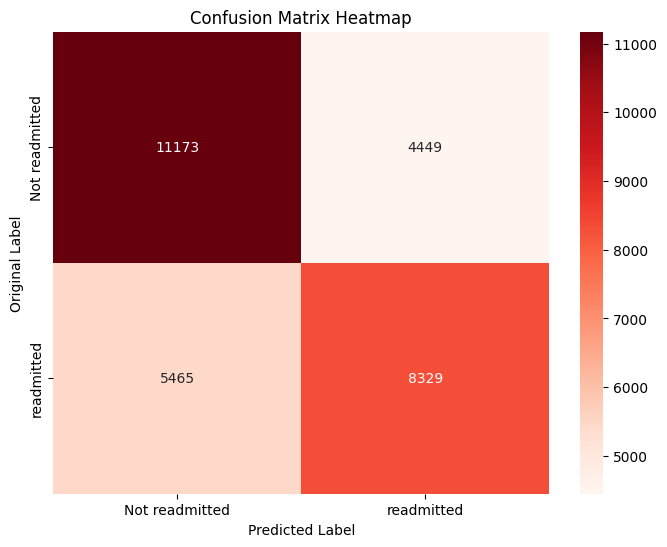

In [44]:
plt.figure(figsize=(8, 6))
class_names = ['Not readmitted', 'readmitted']
sns.heatmap(confusion_matrix(y_test, prediction1), annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Original Label')
plt.show()

**Now, the final model with best parameters shows some improvents. So, lets look at the result. From the final confusion matrix we can observe that the model tends to have more false negatives compared to false positives.**

- The model shows a very minute improvement in accuracy from 66% to 66.3% which means now 66.3% of both positive and negatives were correct
- In case of precision the model shows no improvement.
-Recall has been iproved by almost 1 % from 70.44% to 71.5% which indicates that the model is fairly good at catching most cases of readmission
-There is also minute improvement in F1-Score, from 68.7% to 69.2% which indicates that the model provides a balanced performance

These result will help the healthcare professional to come up with better strategies to improve quality of care and reduce penalties on hospitals and further reducing overall spending from both patient and hospital side.